In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx

import plotly.express as px
import plotly

from utils.portfolios import MarkovPortfolio, TobinPortfolio, SharpPortfolio, TreynorPortfolio, JensenPortfolio

from utils.utils import *

import matplotlib.dates as mdates
import seaborn as sns

import pandas_datareader.data as web   

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
ret_det_for_all = 0.04
risk_det_for_all = 0.09
market = 'usa' # cab be rus or usa (str)

if market == 'usa':
    index_name = '^GSPC' # ticker of SP500
else:
    index_name = 'IMOEX'

# Data loading

In [3]:
df_all = pd.read_csv(f'data/data_all_{market}.csv', index_col=0)
df_all.index = pd.to_datetime(df_all.index)

In [4]:
if index_name in df_all.columns:
    assets = df_all.drop([index_name], axis=1).columns
else:
    assets = df_all.columns

In [5]:
df_all_pct = df_all.pct_change().iloc[1:]
df_all_pct

AAPL      AMZN      BABA       DIS      EBAY         F  \
TRADEDATE                                                                
2015-01-05 -0.028172 -0.020517 -0.025097 -0.014613 -0.008361 -0.039062   
2015-01-06  0.000094 -0.022833  0.022970 -0.005304 -0.012917 -0.009485   
2015-01-07  0.014022  0.010600 -0.011518  0.010230 -0.001636  0.028728   
2015-01-08  0.038422  0.006836  0.028395  0.010341  0.026943  0.025266   
2015-01-09  0.001073 -0.011749 -0.019137  0.004905 -0.013827 -0.013619   
...              ...       ...       ...       ...       ...       ...   
2021-10-28  0.024992  0.015941  0.003309  0.000767 -0.067602  0.087041   
2021-10-29 -0.018156 -0.021511 -0.028565 -0.003595  0.059522  0.013049   
2021-11-01 -0.005607 -0.016107  0.031708  0.006624 -0.005474  0.050937   
2021-11-02  0.007116 -0.001615 -0.042722 -0.002115 -0.018349  0.003343   
2021-11-03  0.009799  0.021508  0.020503  0.001472  0.007343  0.034425   

                  FB     GOOGL      INTC        KO       MCD      MSFT  \
TRADEDATE                                                                
2015-01-05 -0.016061 -0.019054 -0.011276  0.000000 -0.011044 -0.009196   
2015-01-06 -0.013473 -0.024679 -0.018637  0.007594  0.001843 -0.014677   
2015-01-07  0.000000 -0.002941  0.020975  0.012482  0.017424  0.012705   
2015-01-08  0.026658  0.003484  0.018601  0.012096  0.003723  0.029418   
2015-01-09 -0.005628 -0.012211  0.001908 -0.011032 -0.012187 -0.008405   
...              ...       ...       ...       ...       ...       ...   
2021-10-28  0.015054 -0.002520  0.003967  0.009366  0.011412  0.003651   
2021-10-29  0.020983  0.015064  0.019135  0.005889  0.000204  0.022414   
2021-11-01  0.019810 -0.030727  0.011224 -0.003548  0.020485 -0.006785   
2021-11-02 -0.005758  0.013488  0.006256 -0.001246 -0.005348  0.011416   
2021-11-03  0.010790  0.008014  0.010630  0.003387  0.004654  0.002612   

                NFLX       NKE      SBUX         T      TSLA     ^GSPC  
TRADEDATE                                                               
2015-01-05 -0.050897 -0.016100 -0.019155 -0.009448 -0.042041 -0.018278  
2015-01-06 -0.017121 -0.005882 -0.008137  0.001490  0.005664 -0.008893  
2015-01-07  0.005192  0.020656  0.024612 -0.012798 -0.001562  0.011630  
2015-01-08  0.022188  0.023084  0.016137  0.009949 -0.001564  0.017888  
2015-01-09 -0.015458 -0.011024 -0.032731 -0.002985 -0.018802 -0.008404  
...              ...       ...       ...       ...       ...       ...  
2021-10-28  0.016789  0.012997 -0.002731  0.019553  0.037751  0.009829  
2021-10-29  0.024123  0.017208 -0.062986 -0.011350  0.034316  0.001949  
2021-11-01 -0.013240 -0.005738  0.035165  0.004355  0.084910  0.001800  
2021-11-02 -0.005065  0.009018  0.015027 -0.005518 -0.030275  0.003680  
2021-11-03  0.015596  0.027826  0.010408 -0.001982  0.035717  0.006461  

[1722 rows x 18 columns]

# Backtesting

In [6]:
# variable with results
indics = pd.DataFrame(df_all[index_name].values, index=df_all[index_name].index, columns=['data'])
indics = indics[(indics.index > datetime(2018, 1, 1)) & (indics.index < datetime(2018 + 4, 1, 1))]
indics['cumprod'] = (indics.pct_change() + 1).cumprod()
indics['portfolio'] = indics['cumprod'] / indics['cumprod'].shift() - 1
indics = indics.iloc[2:]

In [7]:
d = dict()
d['indics'] = indics['cumprod']

In [8]:
all_weights_all_years =  pd.DataFrame([])

In [9]:
df_res = pd.DataFrame(calculate_measures(indics), index = ['mean_return', 'mean_risk', 'max_drawndown', 'max_recovery'], columns = [index_name])
df_res

^GSPC
mean_return      0.149573
mean_risk        0.191497
max_drawndown  -33.924960
max_recovery   145.000000

In [10]:
# равновесный портфель
return_portfolio_equal = pd.DataFrame([])

index_in_bool = index_name in df_all.columns
for i in range(4): #цикл, при помощи которого ты скользящее среднее
    

    weights = np.ones(len(assets))/len(assets)
   
    returns_test = df_all_pct[(df_all_pct.index > datetime(2018 + i, 1, 1)) & (df_all_pct.index < datetime(2019 + i, 1, 1))]\
    
    if index_in_bool:
        returns_test = returns_test.drop([index_name], axis=1)

    # расчет динамики портфеля за данный период
    return_portfolio_loc = pd.DataFrame(returns_test.values.dot(weights), index = returns_test.index, columns = ['portfolio'])

    # запись результатов динамики в результирующую переменную
    return_portfolio_equal = pd.concat([return_portfolio_equal, return_portfolio_loc])
    
return_portfolio_equal['temp']  = return_portfolio_equal['portfolio'] + 1
return_portfolio_equal['cumprod'] = return_portfolio_equal['temp'].cumprod()

df_res['Equal'] = calculate_measures(return_portfolio_equal)
d['Equal'] = return_portfolio_equal['cumprod']

In [11]:
df_res

^GSPC       Equal
mean_return      0.149573    0.242020
mean_risk        0.191497    0.209625
max_drawndown  -33.924960  -31.929792
max_recovery   145.000000  185.000000

## Markov

In [12]:
label = 'Markov'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), ret_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

^GSPC       Equal      Markov
mean_return      0.149573    0.242020    0.293811
mean_risk        0.191497    0.209625    0.230052
max_drawndown  -33.924960  -31.929792  -30.274186
max_recovery   145.000000  185.000000  187.000000

In [13]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])
all_weights_all_years

2018      2019      2020      2021 portfolio
AAPL   0.059959  0.061260  0.068676  0.068736    Markov
AMZN   0.078318  0.083613  0.080974  0.058757    Markov
BABA   0.071230  0.077561  0.081969  0.056646    Markov
DIS    0.040712  0.039346  0.039162  0.055461    Markov
EBAY   0.059678  0.054671  0.053156  0.043504    Markov
F      0.050877  0.046802  0.045165  0.058900    Markov
FB     0.069599  0.073644  0.074273  0.066832    Markov
GOOGL  0.064820  0.066909  0.069031  0.061935    Markov
INTC   0.054191  0.065172  0.067499  0.068998    Markov
KO     0.026440  0.020194  0.017677  0.034840    Markov
MCD    0.035699  0.026742  0.023769  0.044692    Markov
MSFT   0.068157  0.069210  0.068131  0.068584    Markov
NFLX   0.102024  0.103209  0.098775  0.064932    Markov
NKE    0.049729  0.050922  0.051807  0.055196    Markov
SBUX   0.054229  0.039870  0.035679  0.055934    Markov
T      0.028032  0.025612  0.026653  0.038628    Markov
TSLA   0.086306  0.095264  0.097603  0.097424    Markov

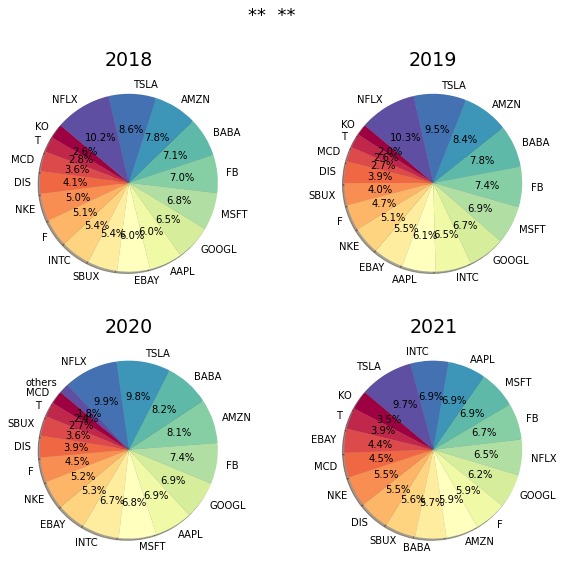

In [14]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == label]
plot_weights_pie(weights_year.iloc[:, :-1].T.values, assets)

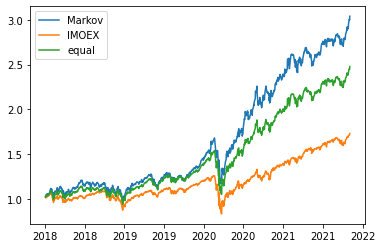

In [15]:
fig, ax = plt.subplots(1)

plt.plot(d['Markov'],label='Markov')
plt.plot(d['indics'],label='IMOEX')
plt.plot(d['Equal'],label='equal')

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

plt.legend()

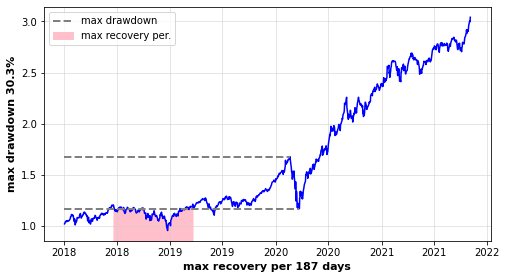

In [16]:
show_stats_of_stock(d['Markov'])

## Tobin

In [17]:
label = 'Tobin'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), port_model = TobinPortfolio, risk_det=risk_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

^GSPC       Equal      Markov       Tobin
mean_return      0.149573    0.242020    0.293811    0.364250
mean_risk        0.191497    0.209625    0.230052    0.271099
max_drawndown  -33.924960  -31.929792  -30.274186  -29.480177
max_recovery   145.000000  185.000000  187.000000  187.000000

In [18]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Treynor

In [19]:
label = 'Treynor'

weights_year, return_portfolio = backtesting_treynor_jensen(df_all_pct, index_ticker=index_name, port_model = TreynorPortfolio, return_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

^GSPC       Equal      Markov       Tobin     Treynor
mean_return      0.149573    0.242020    0.293811    0.364250    0.296592
mean_risk        0.191497    0.209625    0.230052    0.271099    0.276521
max_drawndown  -33.924960  -31.929792  -30.274186  -29.480177  -32.171469
max_recovery   145.000000  185.000000  187.000000  187.000000  154.000000

In [20]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Jensen

In [21]:
n = 16
x = np.ones(n)
np.eye(n) @ x < 0.3

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [22]:
label = 'Jensen'

weights_year, return_portfolio = backtesting_treynor_jensen(df_all_pct, index_ticker=index_name, port_model = JensenPortfolio, return_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

^GSPC       Equal      Markov       Tobin     Treynor  \
mean_return      0.149573    0.242020    0.293811    0.364250    0.296592   
mean_risk        0.191497    0.209625    0.230052    0.271099    0.276521   
max_drawndown  -33.924960  -31.929792  -30.274186  -29.480177  -32.171469   
max_recovery   145.000000  185.000000  187.000000  187.000000  154.000000   

                   Jensen  
mean_return      0.142751  
mean_risk        0.226078  
max_drawndown  -36.774275  
max_recovery   191.000000

In [23]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Sharp

In [24]:
class SharpPortfolio:
    def __init__(self, returns, cov_mat, args):
        self.returns = returns
        self.cov_mat = cov_mat
        self.ret_det = args['ret_det']
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)
        ones_vec = np.ones(n)

        obj = cvx.Maximize(self.returns.T @ x - self.ret_det - cvx.matrix_frac(x, self.cov_mat))
        constraints = [np.ones(n).T @ x == 1,
                      np.eye(n) @ x <= 0.3]

        prob = cvx.Problem(obj, constraints)
        prob.solve()

        weights = x.value
        return weights

In [25]:
label = 'Sharp'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), port_model = SharpPortfolio, ret_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

^GSPC       Equal      Markov       Tobin     Treynor  \
mean_return      0.149573    0.242020    0.293811    0.364250    0.296592   
mean_risk        0.191497    0.209625    0.230052    0.271099    0.276521   
max_drawndown  -33.924960  -31.929792  -30.274186  -29.480177  -32.171469   
max_recovery   145.000000  185.000000  187.000000  187.000000  154.000000   

                   Jensen       Sharp  
mean_return      0.142751    0.314082  
mean_risk        0.226078    0.242166  
max_drawndown  -36.774275  -30.144224  
max_recovery   191.000000  187.000000

In [26]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

# General Results

In [27]:
df_res_final = df_res.T.reset_index()
df_res_final.sort_values(by = 'mean_return')

index  mean_return  mean_risk  max_drawndown  max_recovery
5   Jensen     0.142751   0.226078     -36.774275         191.0
0    ^GSPC     0.149573   0.191497     -33.924960         145.0
1    Equal     0.242020   0.209625     -31.929792         185.0
2   Markov     0.293811   0.230052     -30.274186         187.0
4  Treynor     0.296592   0.276521     -32.171469         154.0
6    Sharp     0.314082   0.242166     -30.144224         187.0
3    Tobin     0.364250   0.271099     -29.480177         187.0

In [28]:
df_res_final.to_excel(f'results/df_res_final_{market}.xlsx', index=None)

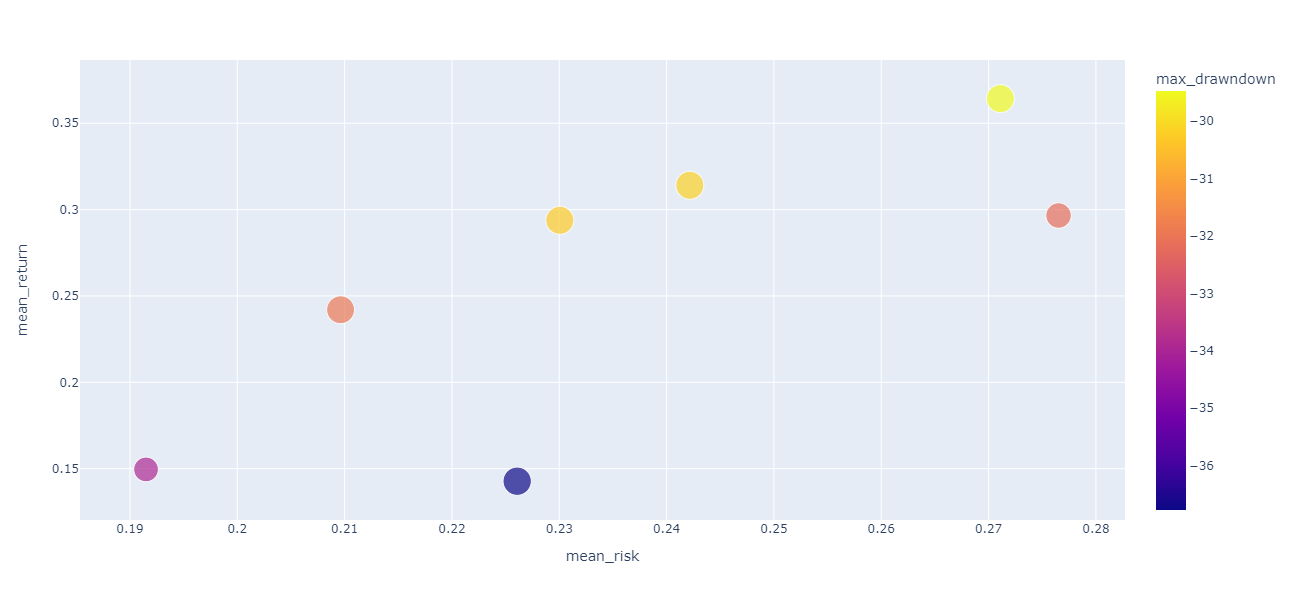

In [29]:
fig = px.scatter(df_res_final, x = 'mean_risk', y = 'mean_return', size='max_recovery',  color="max_drawndown", hover_name = 'index', width=800, height=600)
fig.show()

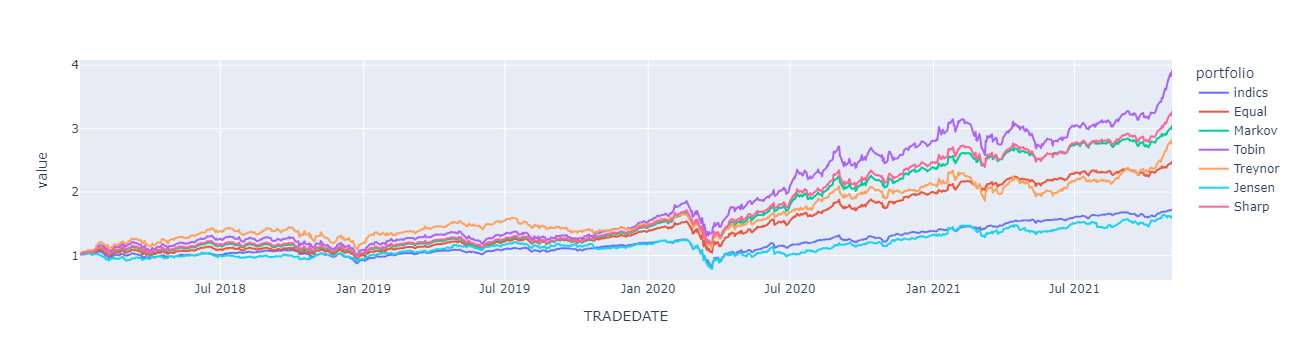

In [30]:
time_res = pd.DataFrame(d).reset_index()
filtr = ['indics', 'Equal', 'Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']
time_res_m = pd.melt(time_res, id_vars=['TRADEDATE'], var_name='portfolio')

time_res_m_filtered = time_res_m.query('portfolio in @filtr')
px.line(time_res_m_filtered, x="TRADEDATE", y="value", color='portfolio')

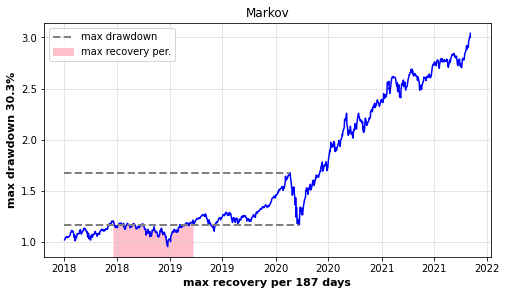

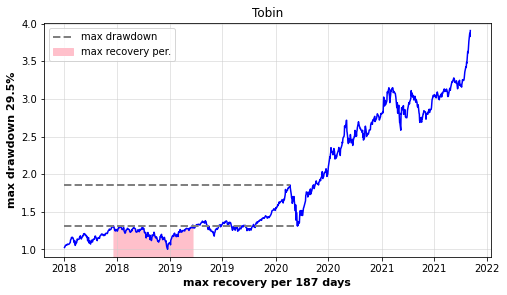

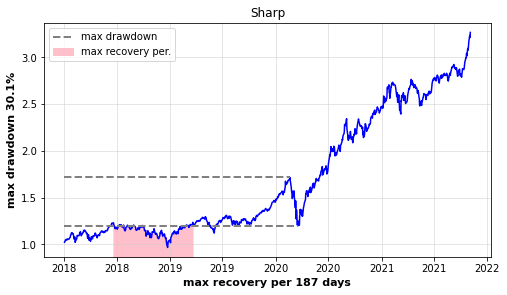

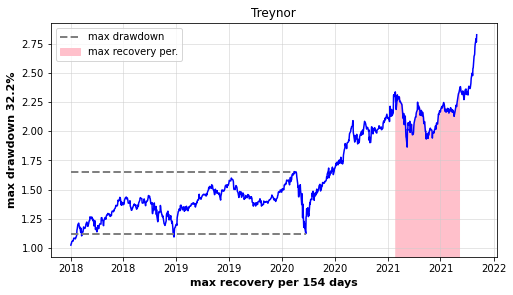

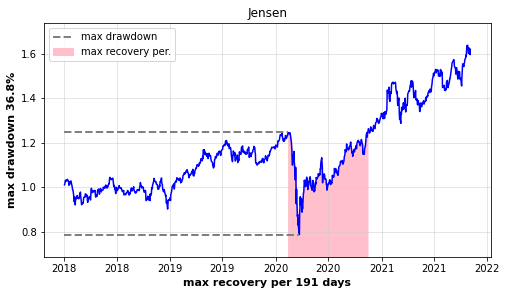

In [31]:
portfolios = ['Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']

for label in portfolios:
    show_stats_of_stock(d[label], label)

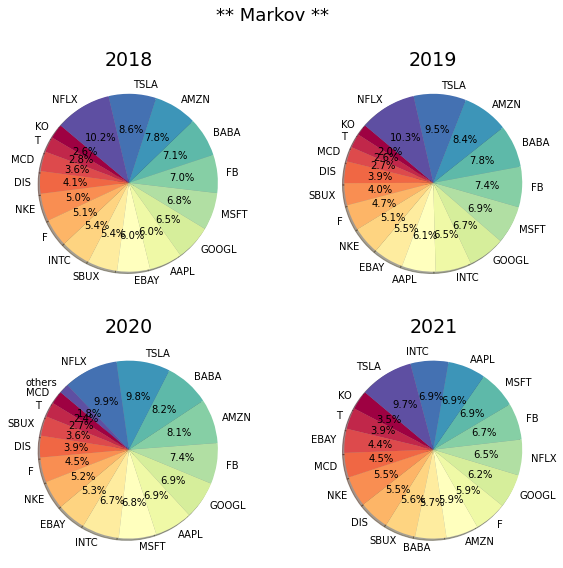

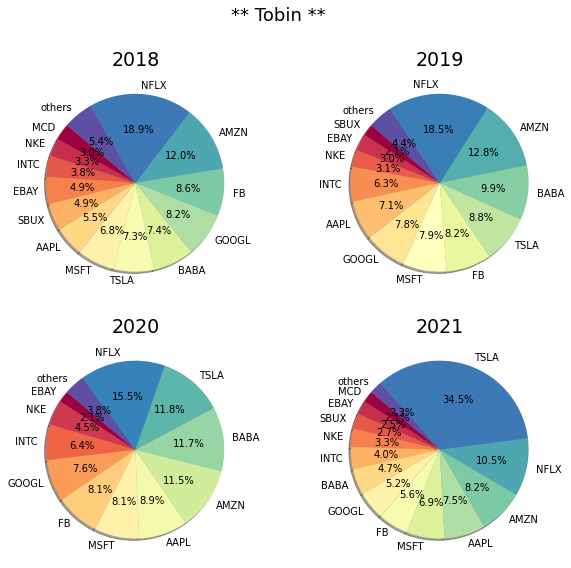

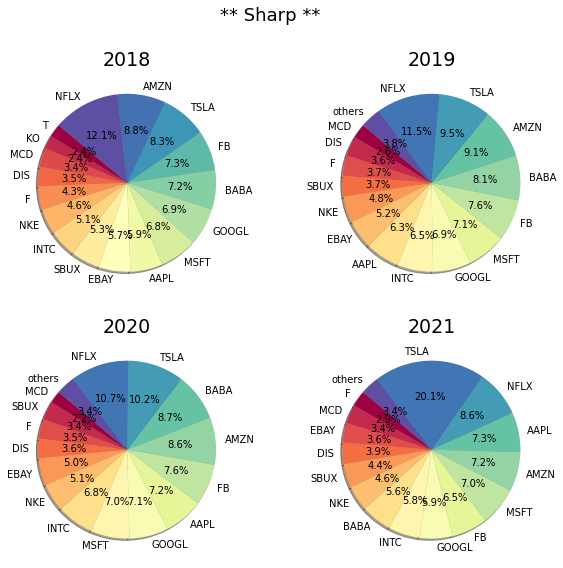

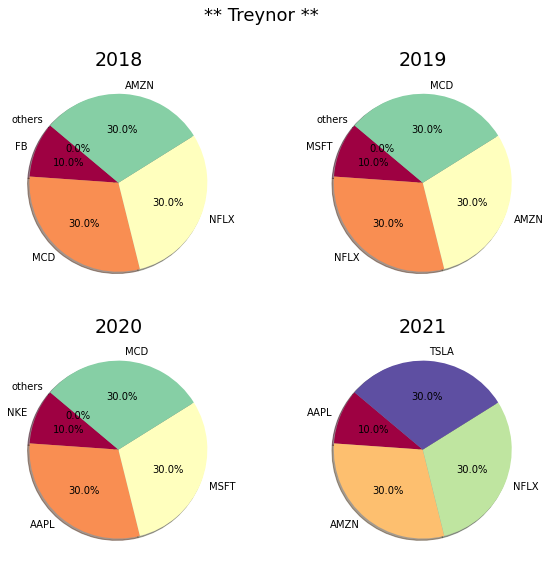

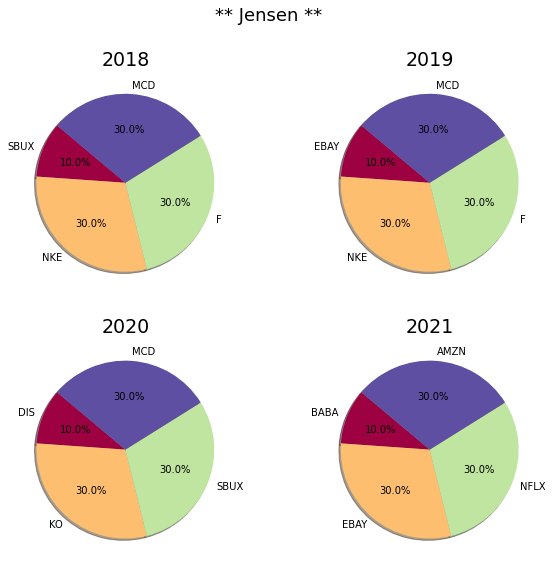

In [32]:
portfolios = ['Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']

for label in portfolios:
    weights_year = all_weights_all_years[all_weights_all_years.portfolio == label]
    plot_weights_pie(weights_year.iloc[:, :-1].T.values, assets, label)

In [33]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == 'Treynor']
weights_year

2018          2019          2020          2021 portfolio
AAPL   4.572909e-07  1.302324e-06  2.999950e-01  9.999766e-02   Treynor
AMZN   2.999997e-01  2.999989e-01  2.534749e-06  2.999992e-01   Treynor
BABA   6.329159e-07  1.658606e-06  3.268819e-06  2.809995e-07   Treynor
DIS    3.945017e-07  5.412474e-07  7.211387e-07  2.961740e-07   Treynor
EBAY   6.107615e-07  4.099334e-07  3.163181e-07  3.527358e-07   Treynor
F      1.997259e-07  2.010647e-07  1.747184e-07  1.753717e-07   Treynor
FB     9.999482e-02  5.571262e-07  6.330035e-07  2.415488e-07   Treynor
GOOGL  1.121823e-06  7.154511e-07  4.642970e-07  2.626866e-07   Treynor
INTC   3.098274e-07  6.334103e-07  4.153809e-07  1.848447e-07   Treynor
KO     6.929075e-07  1.456639e-06  3.789264e-06  3.054689e-07   Treynor
MCD    2.999990e-01  2.999991e-01  2.999987e-01  2.685376e-07   Treynor
MSFT   5.270585e-07  9.999377e-02  2.999962e-01  3.737518e-07   Treynor
NFLX   2.999995e-01  2.999983e-01  1.287884e-06  2.999996e-01   Treynor
NKE    4.887681e-07  6.944931e-07  9.999190e-02  4.270228e-07   Treynor
SBUX   5.096488e-07  6.711190e-07  3.594755e-06  3.285893e-07   Treynor
T      6.787749e-07  3.899111e-07  2.749687e-07  1.963422e-07   Treynor
TSLA   3.364481e-07  6.742423e-07  7.854139e-07  2.999998e-01   Treynor

In [34]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == 'Jensen']
weights_year

2018          2019          2020          2021 portfolio
AAPL   7.434556e-09  2.926754e-10  2.030889e-11  2.571779e-09    Jensen
AMZN   2.186345e-09  7.814057e-11  1.495866e-11  3.000000e-01    Jensen
BABA   9.173804e-09  1.633497e-10  1.789737e-11  9.999980e-02    Jensen
DIS    7.512961e-08  7.101886e-10  1.000000e-01  2.387942e-08    Jensen
EBAY   1.597043e-08  1.000001e-01  1.495730e-10  3.000000e-01    Jensen
F      3.000000e-01  3.000000e-01  1.199436e-10  2.998766e-08    Jensen
FB     4.596695e-09  4.589621e-10  5.261202e-11  1.177637e-08    Jensen
GOOGL  1.053723e-08  3.472930e-10  5.120101e-11  1.174656e-08    Jensen
INTC   1.498707e-08  2.706028e-10  5.160191e-11  3.044098e-08    Jensen
KO     1.447620e-08  7.480216e-10  3.000000e-01  4.713457e-08    Jensen
MCD    3.000000e-01  3.000000e-01  3.000000e-01  5.085033e-08    Jensen
MSFT   2.854121e-09  1.245478e-10  1.912927e-11  3.013635e-09    Jensen
NFLX   8.207757e-10  4.893348e-11  9.947548e-12  3.000000e-01    Jensen
NKE    2.999999e-01  2.999999e-01  1.154735e-10  3.979846e-08    Jensen
SBUX   9.999987e-02  7.614440e-10  3.000000e-01  1.653770e-08    Jensen
T      5.792906e-08  1.698976e-10  8.245803e-11  4.710606e-09    Jensen
TSLA   6.631490e-09  2.562957e-10  3.332253e-11  8.755769e-10    Jensen